In [1]:
import numpy as np 
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

filepath = "/home/rp/abhay_ws/contact-manifold-state-estimation/real_data/BNC_ideal_trajectory.csv"
df = pd.read_csv(filepath)
# rename columns
df = df.rename(columns={
    'axisQMsr_LBR_iiwa_14_R820_1[0]': 'J0',
    'axisQMsr_LBR_iiwa_14_R820_1[1]': 'J1',
    'axisQMsr_LBR_iiwa_14_R820_1[2]': 'J2',
    'axisQMsr_LBR_iiwa_14_R820_1[3]': 'J3',
    'axisQMsr_LBR_iiwa_14_R820_1[4]': 'J4',
    'axisQMsr_LBR_iiwa_14_R820_1[5]': 'J5',
    'axisQMsr_LBR_iiwa_14_R820_1[6]': 'J6',    
})
df.keys()


Index(['ZeitInSec', 'ZeitInNanoSec', 'cartForce1_X', 'cartForceVar1_X',
       'cartForce1_Y', 'cartForceVar1_Y', 'cartForce1_Z', 'cartForceVar1_Z',
       'cartTorque1_TauX', 'cartVarTorque1_TauX', 'cartTorque1_TauY',
       'cartVarTorque1_TauY', 'cartTorque1_TauZ', 'cartVarTorque1_TauZ', 'J0',
       'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'CartPosMsr1_X', 'CartPosMsr1_Y',
       'CartPosMsr1_Z', 'CartPosCmd1_X', 'CartPosCmd1_Y', 'CartPosCmd1_Z'],
      dtype='object')

In [11]:
# forward kinematics 

def z_rotation_matrix(theta): 
    """ Rotation around z-axis """
    return np.array([
        [np.cos(theta), -np.sin(theta), 0, 0],
        [np.sin(theta),  np.cos(theta), 0, 0],
        [0,             0,             1, 0],
        [0,             0,             0, 1]
    ])

def kuka_fk(
        joint_positions, 
        link_lengths = np.array([0.1575, 0.2025, 0.2045, 0.2155, 0.1845, 0.2155, 0.0810, 0.0450]) * 1e3 
    ): 
    if joint_positions.shape[0] == 7:
        joint_positions = np.concatenate((joint_positions, np.array([0])), axis=0) 

    tf_Ji_o = np.empty((8,4,4)) 
    tf_Ji_o[0,:,:] = np.array([
        [ 1.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  1.    ,  0.    ,  0.    ],
        [-0.    ,  0.    ,  1.    ,  link_lengths[0]],
        [ 0.    ,  0.    ,  0.    ,  1.    ]])
    tf_Ji_o[1,:,:] = np.array([
        [-1, 0,  0, 0],
        [ 0, 0,  1, 0],
        [ 0, 1,  0, link_lengths[1]],
        [ 0, 0, 0, 1]])
    tf_Ji_o[2,:,:] = np.array([
        [-1, 0, 0, 0],
        [ 0, 0, 1, link_lengths[2]],
        [ 0, 1, 0, 0],
        [ 0, 0, 0, 1]])
    tf_Ji_o[3,:,:] = np.array([
        [ 1, 0, 0, 0],
        [ 0, 0,-1, 0],
        [ 0, 1, 0, link_lengths[3]],
        [ 0, 0, 0, 1]])
    tf_Ji_o[4,:,:] = np.array([
        [-1, 0, 0, 0],
        [ 0, 0, 1, link_lengths[4]],
        [ 0, 1, 0, 0],
        [ 0, 0, 0, 1]])
    tf_Ji_o[5,:,:] = np.array([
        [ 1, 0,  0,  0],
        [ 0, 0, -1,  0],
        [ 0, 1,  0,  link_lengths[5]],
        [ 0, 0,  0, 1]])
    tf_Ji_o[6,:,:] = np.array([
        [-1, 0, 0, 0],
        [ 0, 0, 1, link_lengths[6]],
        [ 0, 1, 0, 0],
        [ 0, 0, 0, 1]])
    tf_Ji_o[7,:,:] = np.array([
        [ 1,  0,  0,  0.   ],
        [ 0,  1,  0,  0.   ],
        [ 0,  0,  1,  link_lengths[7]],
        [ 0,  0,  0,  1.   ]])
    
    tf = np.eye(4)
    for i in range(8): 
        tf = tf @ tf_Ji_o[i,:,:] @ z_rotation_matrix(joint_positions[i])  
    return tf 

def kuka_fk_batch(
        joint_positions, 
        link_lengths = np.array([0.1575, 0.2025, 0.2045, 0.2155, 0.1845, 0.2155, 0.0810, 0.0450])*1e3
    ): 
    n = joint_positions.shape[0] 
    tf = [] 
    for i in range(n): 
        tf.append(kuka_fk(joint_positions[i,:], link_lengths)) 
    tf = np.array(tf) 
    # tf[:,:3,3] *= 1000 
    tf = tf.reshape((n,4,4))
    return tf 

# filter 
# df_filtered = df 
# df_filtered = df[2500:17500]
df_filtered = df[2500:11000]

# compute end-effector poses
joint_positions = df_filtered[['J0', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6']].values.astype(np.float32) * np.pi / 180.0
tf_ee = kuka_fk_batch(joint_positions)
ee_positions = tf_ee[:,:3,3]
ee_rotations = R.from_matrix(tf_ee[:,:3,:3]).as_euler('xyz', degrees=True)
# ee_rotations = R.from_matrix(tf_ee[:,:3,:3]).as_quat()  # x,y,z,w
# concatenate positions and rotations
c,b,a = ee_rotations[:,0], ee_rotations[:,1], ee_rotations[:,2]
ee_rotations_abc = np.stack((a,b,c), axis=1)  
ee_poses = np.concatenate((ee_positions, ee_rotations_abc), axis=1)
ee_poses.shape

df_filtered['FK_X'] = ee_poses[:,0] 
df_filtered['FK_Y'] = ee_poses[:,1] 
df_filtered['FK_Z'] = ee_poses[:,2] 
df_filtered['FK_A'] = ee_poses[:,3] 
df_filtered['FK_B'] = ee_poses[:,4] 
df_filtered['FK_C'] = ee_poses[:,5] 

df_filtered.describe()

/tmp/ipykernel_3890072/2090047413.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['FK_X'] = ee_poses[:,0]
/tmp/ipykernel_3890072/2090047413.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['FK_Y'] = ee_poses[:,1]
/tmp/ipykernel_3890072/2090047413.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

,ZeitInSec,ZeitInNanoSec,cartForce1_X,cartForceVar1_X,cartForce1_Y,cartForceVar1_Y,cartForce1_Z,cartForceVar1_Z,cartTorque1_TauX,cartVarTorque1_TauX,...,CartPosMsr1_Z,CartPosCmd1_X,CartPosCmd1_Y,CartPosCmd1_Z,FK_X,FK_Y,FK_Z,FK_A,FK_B,FK_C
count,8.500000e+03,8.500000e+03,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,...,8500.000000,8500.000000,8.500000e+03,8.500000e+03,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000
mean,1.357002e+09,5.005000e+08,7.519804,-3.017940,-3.785671,3.395706,-3.829672,-1.884105,-0.842492,-0.276144,...,213.739611,709.028567,-3.995834e+01,2.456984e+02,718.829761,-43.221940,213.739575,148.359617,-0.858288,171.163967
std,1.227360e+01,2.874120e+08,2.288614,4.545647,0.973369,1.214949,1.315261,0.072216,0.442395,0.831749,...,10.493941,0.000000,1.421169e-14,2.842338e-14,0.996239,0.791074,10.493942,33.028531,1.327248,45.423761
min,1.357002e+09,3.000000e+06,3.032332,-5.512012,-6.546122,0.894082,-12.901838,-2.031325,-2.422979,-0.752412,...,201.925674,709.028567,-3.995834e+01,2.456984e+02,716.917743,-45.636765,201.925594,78.386773,-3.650778,-179.996242
25%,1.357002e+09,2.530000e+08,5.374739,-5.473400,-4.472490,3.664910,-4.900140,-1.941881,-1.243714,-0.727280,...,206.170890,709.028567,-3.995834e+01,2.456984e+02,718.070352,-43.598981,206.170854,164.943882,-0.665896,176.399048
50%,1.357002e+09,5.005000e+08,7.210234,-5.370600,-3.739288,3.714110,-4.480562,-1.878254,-0.697118,-0.704360,...,206.207029,709.028567,-3.995834e+01,2.456984e+02,718.405366,-43.379131,206.206991,165.259084,-0.543740,176.514953
75%,1.357002e+09,7.480000e+08,9.762688,-5.348352,-3.207330,3.851234,-2.358905,-1.847646,-0.477574,-0.696154,...,226.784987,709.028567,-3.995834e+01,2.456984e+02,719.813661,-43.061996,226.784955,165.902910,0.153300,176.652182
max,1.357002e+09,9.980000e+08,12.889692,6.234881,1.170107,6.407906,13.185243,-1.653908,0.016847,1.463623,...,227.269383,709.028567,-3.995834e+01,2.456984e+02,721.923798,-41.684743,227.269423,166.824351,0.597303,179.997379


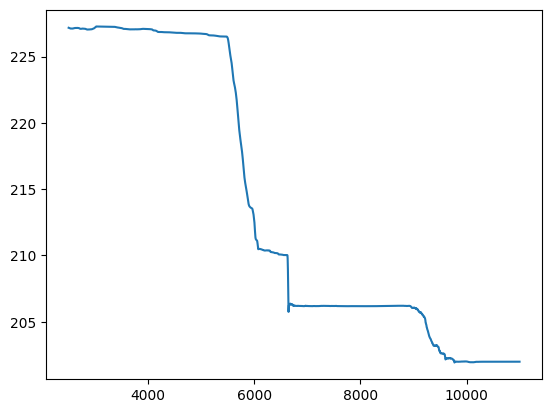

In [12]:
plt.plot(df_filtered['FK_Z'])

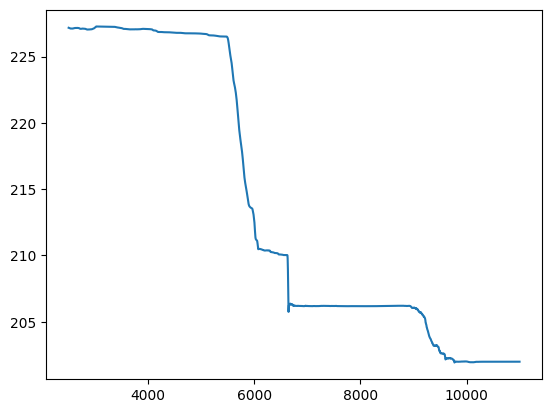

In [15]:
plt.plot(df_filtered['FK_Z'])
# plt.plot(pd.concat([df['FK_A'].iloc[1500:35000], df['FK_A'].iloc[40000:69000]]).values)

In [14]:
# save to csv 
df_filtered.to_csv("/home/rp/abhay_ws/contact-manifold-state-estimation/real_data/BNC_ideal_trajectory_forward_processed.csv", index=False)

In [10]:
# get fully inserted pose (zero frame)
df_filtered.loc[11000,['FK_X','FK_Y','FK_Z','FK_A','FK_B','FK_C']]

FK_X    718.089591
FK_Y    -41.785233
FK_Z    201.984210
FK_A     78.921215
FK_B     -3.352434
FK_C    179.542323
Name: 11000, dtype: float64